In [1]:
import os
import numpy as np
import pandas as pd
import joblib, os, pickle, hashlib, torch, time
import pefile
# from torch.nn.functional import sigmoid
from features import PEFeatureExtractor


c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
from torch.nn import functional as F


class MalConvBase(nn.Module):
    def __init__(self, embed_dim, _, out_channels, window_size, dropout=0.5):
        super(MalConvBase, self).__init__()
        self.embed = nn.Embedding(257, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class MalConvPlus(nn.Module):
    def __init__(self, embed_dim, max_len, out_channels, window_size, dropout=0.5):
        super(MalConvPlus, self).__init__()
        self.tok_embed = nn.Embedding(257, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        tok_embedding = self.tok_embed(x)
        pos = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        pos_embedding = self.pos_embed(pos)
        embedding = self.dropout(tok_embedding + pos_embedding)
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class RCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        residual,
        dropout=0.5,
    ):
        super(RCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(dropout)
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        fc_in = rnn_out[-1]
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output


class AttentionRCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        attn_size,
        residual,
        dropout=0.5,
    ):
        super(AttentionRCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        self.local2attn = nn.Linear(rnn_out_size, attn_size)
        self.global2attn = nn.Linear(rnn_out_size, attn_size, bias=False)
        self.attn_scale = nn.Parameter(
            nn.init.kaiming_uniform_(torch.empty(attn_size, 1))
        )
        self.dropout = nn.Dropout(dropout)
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        global_rnn_out = rnn_out.mean(dim=0)
        attention = torch.tanh(
            self.local2attn(rnn_out) + self.global2attn(global_rnn_out)
        ).permute(1, 0, 2)
        alpha = F.softmax(attention.matmul(self.attn_scale), dim=-1)
        rnn_out = rnn_out.permute(1, 0, 2)
        fc_in = (alpha * rnn_out).sum(dim=1)
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output

In [3]:
def extract_features(data):
    extractor = PEFeatureExtractor(2)
    # temp = extractor.feature_vector(data)
    # print(temp)
    features = np.array(extractor.feature_vector(data), dtype=np.float32)
    pe = pefile.PE(data=data)
    return [features], list(pe.header)


In [7]:
result = []
test = r"./datasets\gw2\0000"
with open(test, "rb") as f:
    data = f.read()
features_data, header = extract_features(data)

# RF 1

In [13]:
clf = joblib.load("../models/malware_classifier_v2.joblib")
features = pickle.load(open("../models/features.pkl", "rb"))
clf.predict_proba(features_data)
# pe_features = np.array([features_data[feature] for feature in features])
# y_pred = clf.predict_proba([pe_features])
# predictions.append(int(prediction1[0]))

array([[0.45078584, 0.54921416]])

# Malconv

In [20]:
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
model.load_state_dict(torch.load(weight_path))
model.to(device)
model.eval()
input = torch.tensor(header).unsqueeze(0).to(device)
y_pred2 = sigmoid(model(input))



# RNN

In [6]:
selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
selected = features_data[0][selected_features]
selected

array([ 0.0000000e+00,  3.3434941e-03,  4.0000000e+00,  4.6179793e-03,
        9.4210152e-03,  2.5288749e-03,  2.8279808e-03,  1.5000000e+01,
        1.2600535e+09,  0.0000000e+00,  2.8295266e-03, -1.0000000e+00,
        1.3463892e-02, -1.0240000e+03], dtype=float32)

In [9]:
from torch import nn

class MalwareDetector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MalwareDetector, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        last_output = out[:, -1, :]
        out = self.fc(last_output)
        return out

selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
input_size = 14
hidden_size = 64
output_size = 2
dl_model = MalwareDetector(input_size, hidden_size, output_size)
dl_path = os.path.join("../models/malware_detector.pth")
dl_model.load_state_dict(torch.load(dl_path))
dl_model.eval()
with open("../models/scaler.pickle", "rb") as f:
    mean, var = pickle.load(f)
std = np.sqrt(var)
with torch.no_grad():
    features_data = (features_data-mean)/std
    selected = [features_data[0][selected_features]]
    features = torch.tensor(selected, dtype=torch.float32)
    output = dl_model(features)
    _, predicted = torch.max(output, 1)
    # predictions.append(predicted.item())

c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


In [10]:
output.tolist()[0]

[-3.501063346862793, 3.095097303390503]

In [26]:
result.append(y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])

# Testing

In [16]:
from tqdm import tqdm
basePath = "./datasets"
all_results = []
# load RF models
clf = joblib.load("../models/malware_classifier_v2.joblib")
# bodmas_clf = joblib.load("../models/bodmas/model.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
malconv = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv.load_state_dict(torch.load(weight_path))
malconv.to(device)
malconv.eval()

selected_features = [2379, 32, 683, 17, 596, 126, 106, 613, 626, 637, 164, 641, 592, 725]
input_size = 14
hidden_size = 64
output_size = 2
dl_model = MalwareDetector(input_size, hidden_size, output_size)
dl_path = "../models/malware_detector.pth"
dl_model.load_state_dict(torch.load(dl_path))
dl_model.eval()

with open("../models/scaler.pickle", "rb") as f:
    mean, var = pickle.load(f)

for folder in os.listdir(basePath):
    if "mw" in folder:
        label = 1
    else:
        label = 0
    results = []
    folderPath = os.path.join(basePath, folder)
    fileCount = 0
    if os.path.isfile(folderPath):
        continue
    for file in tqdm(os.listdir(folderPath)):
        filePath = os.path.join(folderPath, file)
        # print(filePath)
        # break
        with open(filePath, "rb") as f :
            data = f.read()
        try:
            features_data, header = extract_features(data)
        except:
            results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 1.0, 0.0])
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0])
            continue
        input = torch.tensor(header).unsqueeze(0).to(device)
        y_pred = clf.predict_proba(features_data)
        with torch.no_grad():
            y_pred2 = torch.sigmoid(malconv(input))
            features_data = (features_data-mean)/std
            selected = [features_data[0][selected_features]]
            # print(selected)
            features = torch.tensor(selected, dtype=torch.float32)
            y_pred3 = dl_model(features)
            # y_pred3 = torch.softmax(y_pred3, dim = -1)
            _, predicted = torch.max(y_pred3, 1)
        # pe_features = np.array([features_data[feature] for feature in features])
        # y_pred3 = bodmas_clf.predict_proba([pe_features])
        results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() )
        # break
    all_results += results
    # break
# all_results

  0%|          | 0/17 [00:00<?, ?it/s]

c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
  7%|▋         | 4/58 [00:02<00:29,  1.84it/s]c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 59%|█████▊    | 34/58 [00:15<00:09,  2.45it/s]

lief error:  This file is not a PE binary


c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 64%|██████▍   | 37/58 [00:16<00:06,  3.25it/s]c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
 84%|████████▍ | 49/58 [00:21<00:03,  2.34it/s]c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
  8%|▊         | 4/49 [00:01<00:18,  2.40it/s]c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
c:

In [17]:
df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1", "y_pred2_0", "y_pred2_1"])
# df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1"])
# df2 = df
# len(all_results)

In [13]:
df.tail()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1
125,mw8_0005,mw8,1,0.000041,0.999959,1.000000,1.645712,-1.691952
126,mw8_0006,mw8,1,0.010719,0.989281,0.622618,-4.018032,4.224838
127,mw8_0007,mw8,1,0.101262,0.898738,0.790157,7.399960,-7.439570
128,mw8_0008,mw8,1,0.200739,0.799261,0.003563,6.799582,-6.941023
129,mw8_0009,mw8,1,0.631986,0.368014,0.997866,-2.800785,2.571718


In [16]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x /e_x.sum(axis=1, keepdims=True)
df[['y_pred2_0', 'y_pred2_1']] = softmax(df[['y_pred2_0', 'y_pred2_1']].values)

In [17]:
df['pred0_label'] = (df['y_pred0_1'] > 0.45).astype(int)
df['pred1_label'] = (df['y_pred1'] > 0.5).astype(int)
df['pred2_label'] = (df['y_pred2_1'] > 0.45).astype(int)

# df['pred0_label'] = df[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
# df['pred2_label'] = df[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
df['vote'] = (df['pred0_label'] + df['pred1_label'] + df['pred2_label'] >= 2).astype(int)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1,pred1_label,pred0_label,pred2_label,vote,correct_pred0,correct_pred1,correct_pred2
0,gw2_0000,gw2,0,0.450786,0.549214,0.817315,1.363739e-03,9.986363e-01,1,1,1,1,0,0,0
1,gw2_0001,gw2,0,0.433744,0.566256,0.782296,1.619705e-03,9.983803e-01,1,1,1,1,0,0,0
2,gw2_0002,gw2,0,0.280016,0.719984,0.000407,1.000000e+00,2.384533e-09,0,1,0,0,0,1,1
3,gw2_0003,gw2,0,0.180803,0.819197,0.010278,1.193956e-13,1.000000e+00,0,1,1,1,0,1,0
4,gw2_0004,gw2,0,0.280012,0.719988,0.956456,3.351372e-11,1.000000e+00,1,1,1,1,0,0,0


In [5]:
df.to_csv("all_reults_v2.csv")

NameError: name 'df' is not defined

In [4]:
df = pd.read_csv("all_reults_v2.csv", index_col=0)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1,pred1_label,pred0_label,pred2_label,vote,correct_pred0,correct_pred1,correct_pred2
0,gw2_0000,gw2,0,0.450786,0.549214,0.817315,1.363739e-03,9.986363e-01,1,1,1,1,0,0,0
1,gw2_0001,gw2,0,0.433744,0.566256,0.782296,1.619705e-03,9.983803e-01,1,1,1,1,0,0,0
2,gw2_0002,gw2,0,0.280016,0.719984,0.000407,1.000000e+00,2.384533e-09,0,1,0,0,0,1,1
3,gw2_0003,gw2,0,0.180803,0.819197,0.010278,1.193956e-13,1.000000e+00,0,1,1,1,0,1,0
4,gw2_0004,gw2,0,0.280012,0.719988,0.956456,3.351372e-11,1.000000e+00,1,1,1,1,0,0,0


In [7]:
df[df['Dataset']=='gw6']

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1,pred1_label,pred0_label,pred2_label,vote,correct_pred0,correct_pred1,correct_pred2,pipeline
197,gw6_0000,gw6,0,0.889973,0.110027,2.590764e-01,1.0,1.504865e-11,0,0,0,0,1,1,1,0
198,gw6_0001,gw6,0,0.709970,0.290030,2.144855e-07,1.0,9.302329e-09,0,0,0,0,1,1,1,0
199,gw6_0002,gw6,0,0.979790,0.020210,6.898820e-08,1.0,4.490030e-12,0,0,0,0,1,1,1,0
200,gw6_0003,gw6,0,0.979846,0.020154,7.277200e-03,1.0,5.690270e-12,0,0,0,0,1,1,1,0
201,gw6_0004,gw6,0,0.959928,0.040072,9.303364e-02,1.0,1.106643e-11,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,gw6_0077,gw6,0,0.899959,0.100041,9.355638e-03,1.0,9.805144e-12,0,0,0,0,1,1,1,0
275,gw6_0078,gw6,0,0.869973,0.130027,2.779504e-04,1.0,3.439411e-11,0,0,0,0,1,1,1,0
276,gw6_0079,gw6,0,0.959957,0.040043,4.980220e-04,1.0,1.941432e-12,0,0,0,0,1,1,1,0
277,gw6_0080,gw6,0,0.969847,0.030153,2.128054e-04,1.0,1.177123e-12,0,0,0,0,1,1,1,0


In [5]:
def pipeline(malconv, rf):
    if malconv > 0.5 :
        return 1
    elif rf > 0.5:
        return 1
    else:
        return 0


df['pipeline'] = df.apply(lambda x: pipeline(x['y_pred1'], x['y_pred0_1']), axis=1)
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1,pred1_label,pred0_label,pred2_label,vote,correct_pred0,correct_pred1,correct_pred2,pipeline
0,gw2_0000,gw2,0,0.450786,0.549214,0.817315,1.363739e-03,9.986363e-01,1,1,1,1,0,0,0,1
1,gw2_0001,gw2,0,0.433744,0.566256,0.782296,1.619705e-03,9.983803e-01,1,1,1,1,0,0,0,1
2,gw2_0002,gw2,0,0.280016,0.719984,0.000407,1.000000e+00,2.384533e-09,0,1,0,0,0,1,1,1
3,gw2_0003,gw2,0,0.180803,0.819197,0.010278,1.193956e-13,1.000000e+00,0,1,1,1,0,1,0,1
4,gw2_0004,gw2,0,0.280012,0.719988,0.956456,3.351372e-11,1.000000e+00,1,1,1,1,0,0,0,1


In [6]:
def calculate_accuracy(group):
    acc_pred0 = (group['pred0_label'] == group['Label']).mean()
    acc_pred1 = (group['pred1_label'] == group['Label']).mean()
    acc_pred2 = (group['pred2_label'] == group['Label']).mean()
    acc_vote = (group['pipeline'] == group['Label']).mean()
    # vote = (group['pred0_label'] + group['pred1_label'] + group['pred2_label'] >= 2).astype(int).mean()
    return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, 'Accuracy_pred2': acc_pred2, "Pipeline":acc_vote})
    # return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1})

# Group by 'Dataset' and apply the accuracy function
accuracy_results = df.groupby('Dataset').apply(calculate_accuracy)
accuracy_results

,Accuracy_pred0,Accuracy_pred1,Accuracy_pred2,Pipeline
Dataset,,,,
gw2,0.117647,0.529412,0.470588,0.176471
gw3,0.327586,0.603448,0.465517,0.310345
gw4,0.571429,0.591837,0.387755,0.428571
gw5,0.479452,0.287671,0.794521,0.287671
gw6,1.000000,0.963415,0.963415,0.963415
mw1,0.375000,0.750000,0.375000,0.750000
mw2,0.820000,0.860000,0.700000,0.880000
mw3,0.383333,0.700000,0.416667,0.733333
mw4,0.758621,0.724138,0.310345,0.862069


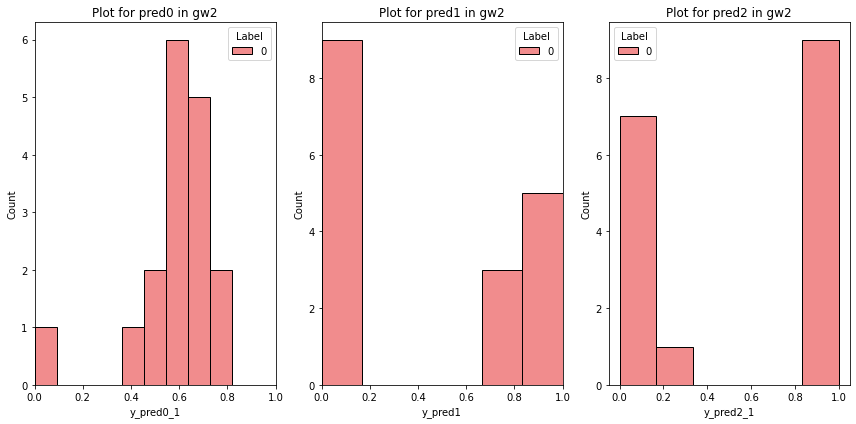

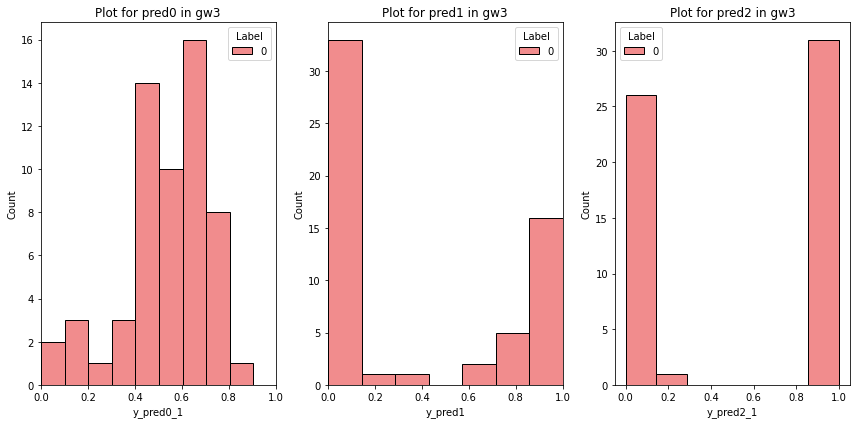

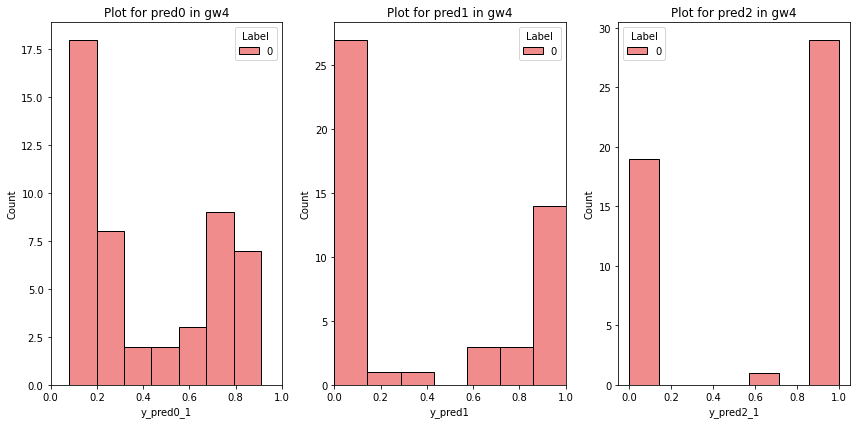

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
df_viz = df
# Adding new columns for predicted labels
df_viz['pred0_label'] = df_viz[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
df_viz['pred1_label'] = (df_viz['y_pred1'] > 0.5).astype(int)
df_viz['pred2_label'] = df_viz[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))


# Adding columns for correctness
df_viz['correct_pred0'] = (df_viz['pred0_label'] == df_viz['Label']).astype(int)
df_viz['correct_pred1'] = (df_viz['pred1_label'] == df_viz['Label']).astype(int)
df_viz['correct_pred2'] = (df_viz['pred2_label'] == df_viz['Label']).astype(int)

datasets = df_viz['Dataset'].unique()
for dataset in datasets:
    plt.figure(figsize=(12, 6))
        
        # Data filtered by current dataset
        
    data_subset = df_viz[df_viz['Dataset'] == dataset]
    # data_subset = df
    # dataset = ""
    # Plot for pred0
    plt.subplot(1, 3, 1)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred0_0' if "gw" in dataset else 'y_pred0_1'
    sns.histplot(data=data_subset, x='y_pred0_1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred0 in {dataset}')
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    plt.subplot(1, 3, 2)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred1_0' if "gw" in dataset else 'y_pred0_1'
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    sns.histplot(data=data_subset, x='y_pred1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred1 in {dataset}')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    # # Plot for pred2
    plt.subplot(1, 3, 3)
    # # col_name = 'y_pred2_0' if "gw" in dataset else 'y_pred2_1'
    # # sns.scatterplot(data=data_subset, x='y_pred2_0', y='y_pred2_1', hue='correct_pred2', style='Dataset',
    #                 # palette='Set1', markers=True, legend='full')
    # # plt.xlabel('Benign Probability')
    # # plt.ylabel('Malware Probability')
    sns.histplot(data=data_subset, x='y_pred2_1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred2 in {dataset}')
    # plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
    # Show plot
    plt.tight_layout()
    plt.show()